In [182]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

df = pd.read_csv("datasets/pr6/mall_customers.csv")

df = df.drop(columns=['customer_id'])

le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])

print(*[[i, v] for i, v in enumerate(le.classes_)])

df.info()

[0, 'Female'] [1, 'Male']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   gender          200 non-null    int64
 1   age             200 non-null    int64
 2   annual_income   200 non-null    int64
 3   spending_score  200 non-null    int64
dtypes: int64(4)
memory usage: 6.4 KB


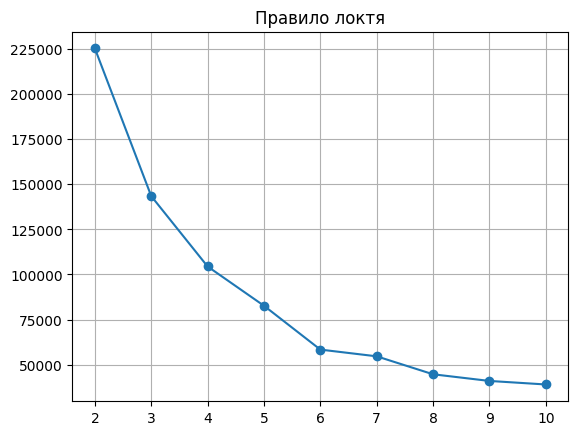

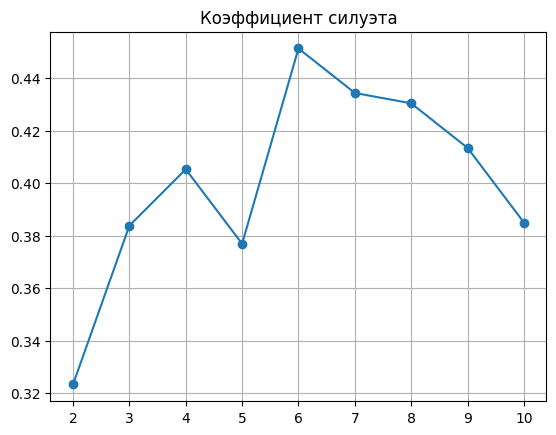

In [183]:
# 2. Провести кластеризацию данных с помощью алгоритма k-means.
# Использовать «правило локтя» и коэффициент силуэта
# для поиска оптимального количества кластеров.
import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

models = []
inertia = []
silhouette_scores = []

for i in range(2, 11):
    model = KMeans(n_clusters=i, random_state=43, init='k-means++').fit(df)
    models.append(model)
    # «правило локтя»
    inertia.append(model.inertia_)
    # коэффициент силуэта
    silhouette_scores.append(silhouette_score(df, model.labels_))

plt.grid()
plt.title("Правило локтя")
plt.plot(np.arange(2, 11), inertia, marker='o')
plt.show()
plt.grid()
plt.title("Коэффициент силуэта")
plt.plot(np.arange(2, 11), silhouette_scores, marker='o')
plt.show()

# по правилу локтя i = 6 – «точка локтя» находится в x = 6
# значит, по правилу локтя нужно выбрать 6 кластеров

# по коэффициенту силуэта стоит выбирать i = 6 – при таких значениях
# точки наиболее хорошо разделены на кластера
# (чем выше значение средних коэффициентов силуэта, тем лучше кластеризация)

# стоит выбирать оценку по правилу локтя, если приоритет — четкость и разделение кластеров
# стоит выбирать оценку по коэффициенту силуэта, если приоритет — объясненная инерция и сохранение структуры данных

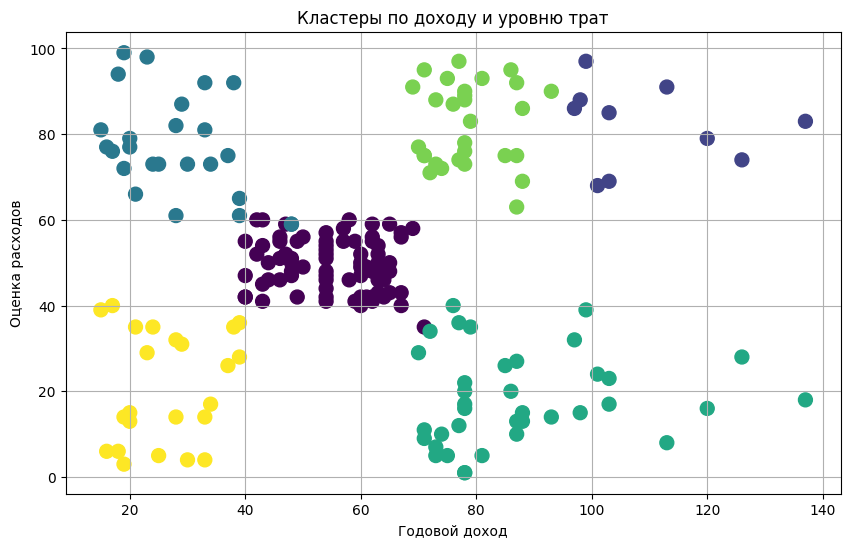

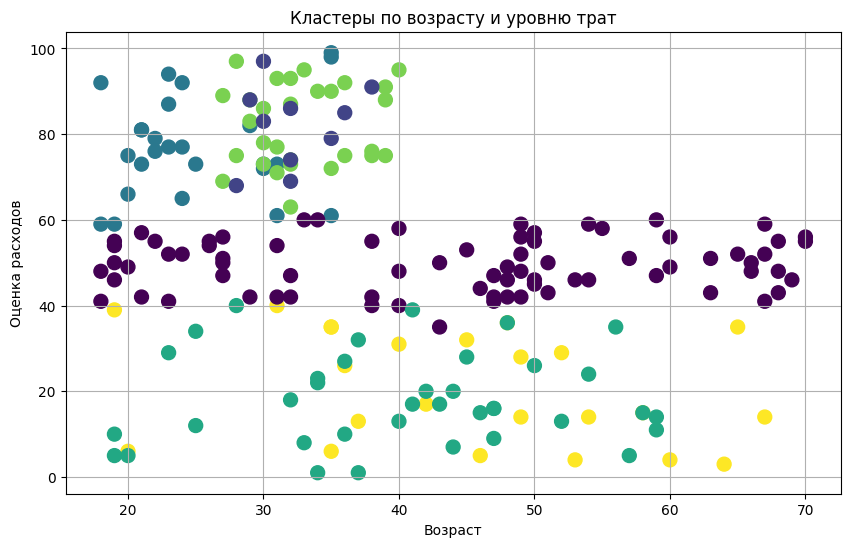

In [190]:
# 3. Провести кластеризацию данных с помощью алгоритма kmeans.
from sklearn.cluster import KMeans

start = time.perf_counter()

kmeans = KMeans(n_clusters=6, random_state=42, init='k-means++')
kmeans.fit(df)

kmeans_delta = time.perf_counter() - start

labels = kmeans.labels_
df['cluster'] = labels

def viz_cluster_2d(cluster_df):
    # визуализируем доход и уровень трат
    plt.figure(figsize=(10, 6))
    
    plt.scatter(df['annual_income'], df['spending_score'], c=cluster_df, cmap='viridis', s=100)
    
    # центроиды кластеров
    centroids = kmeans.cluster_centers_
    # plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=300, alpha=0.6, marker='x', label='Centroids')
    # plt.legend()
    
    plt.title('Кластеры по доходу и уровню трат')
    plt.xlabel('Годовой доход')
    plt.ylabel('Оценка расходов')
    plt.grid(True)
    plt.show()
    
    # визуализируем доход и уровень трат
    plt.figure(figsize=(10, 6))
    
    plt.scatter(df['age'], df['spending_score'], c=df['cluster'], cmap='viridis', s=100)
    
    # центроиды кластеров
    centroids = kmeans.cluster_centers_
    # plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=300, alpha=0.6, marker='x', label='Centroids')
    # plt.legend()
    
    plt.title('Кластеры по возрасту и уровню трат')
    plt.xlabel('Возраст')
    plt.ylabel('Оценка расходов')
    plt.grid(True)
    plt.show()

viz_cluster_2d(df['cluster'])

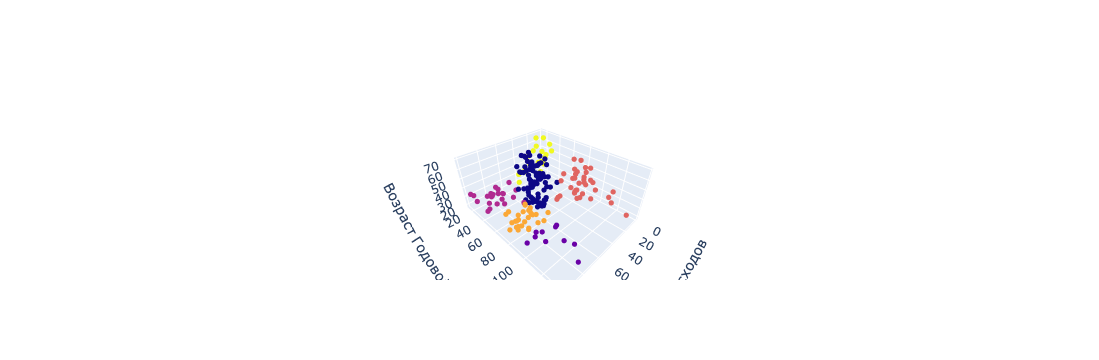

In [185]:
import plotly.graph_objects as go

def viz_cluster_3d():
    fig = go.Figure(data=[go.Scatter3d(
        x=df['spending_score'],
        y=df['annual_income'],
        z=df['age'],
        mode='markers',
        marker_color=df['cluster'],
        marker_size=3,
    )])
    fig.update_layout(
        scene=dict(
            xaxis_title='Оценка расходов',
            yaxis_title='Годовой доход',
            zaxis_title='Возраст'
        ),
        legend_title_text='Кластеры'
    )
    
    fig.show()

viz_cluster_3d()

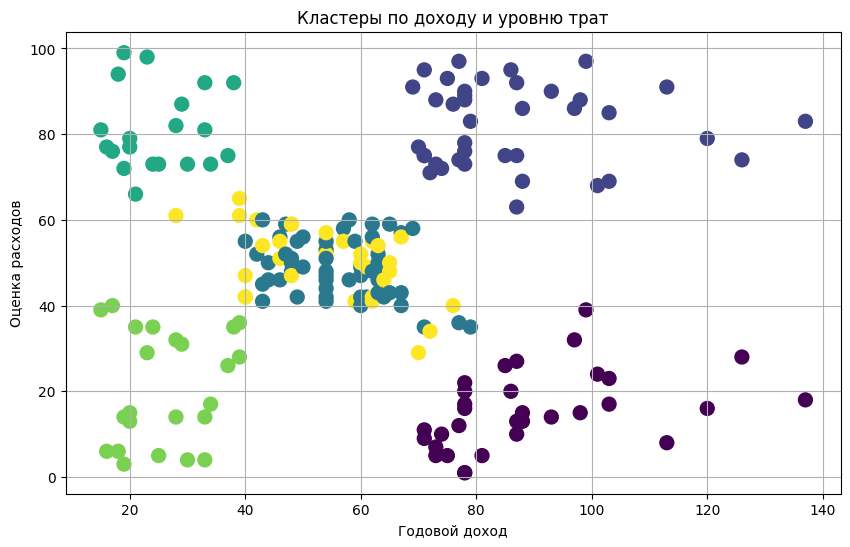

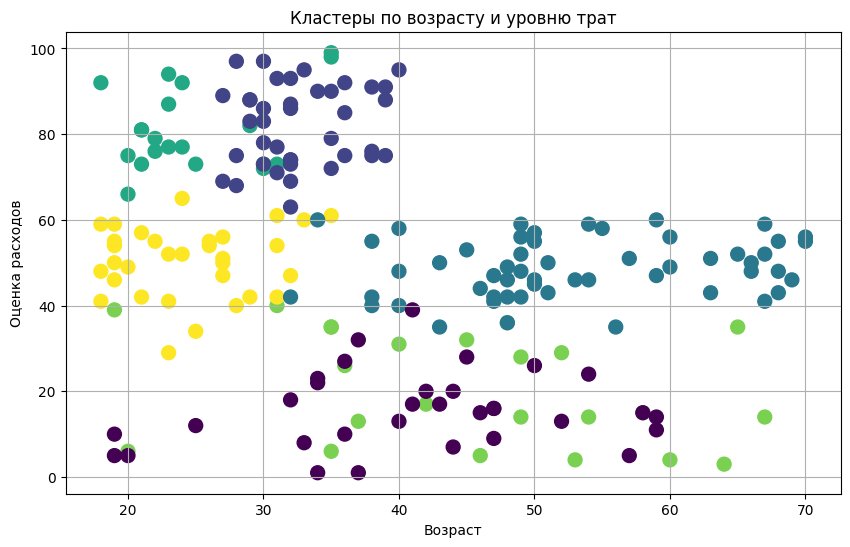

In [186]:
# 3. Провести кластеризацию данных с помощью алгоритма иерархической кластеризации.
from sklearn.cluster import AgglomerativeClustering

start = time.perf_counter()

agl = AgglomerativeClustering(6, compute_distances=True)
clustering = agl.fit(df)

agglomerative_delta = time.perf_counter() - start

labels = agl.labels_
df['cluster'] = labels

viz_cluster_2d(df['cluster'])

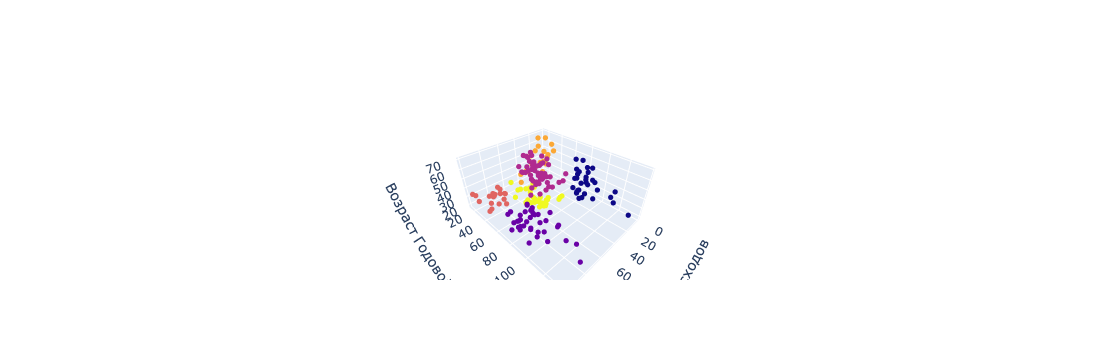

In [149]:
viz_cluster_3d()

In [187]:
# 4. Провести кластеризацию данных с помощью алгоритма DBSCAN
from sklearn.cluster import DBSCAN

start = time.perf_counter()

# - eps – эпсилон: радиус поиска (максимальное расстояние между
# двумя точками, чтобы они считались соседями)
# - min_samples – условие по плотности (минимальное количество точек для формирования кластера)
# Для каждой точки ищем соседей в пределах заданного радиуса eps.
# Если количество соседних точек достаточно для удовлетворения условия
# по плотности (min_samples), точка считается "ключевой", и вокруг нее образуется кластер.
# eps = 10, min_samples = 6 – лучшая из комбинаций показателей, что мне удалось подобрать
dbscan_model = DBSCAN(eps=10, min_samples=6)
dbscan = dbscan_model.fit(df)

dbscan_delta = time.perf_counter() - start

labels = dbscan.labels_
df['cluster'] = labels

print(df['cluster'].value_counts())

cluster
-1    82
 1    77
 2    29
 0    12
Name: count, dtype: int64


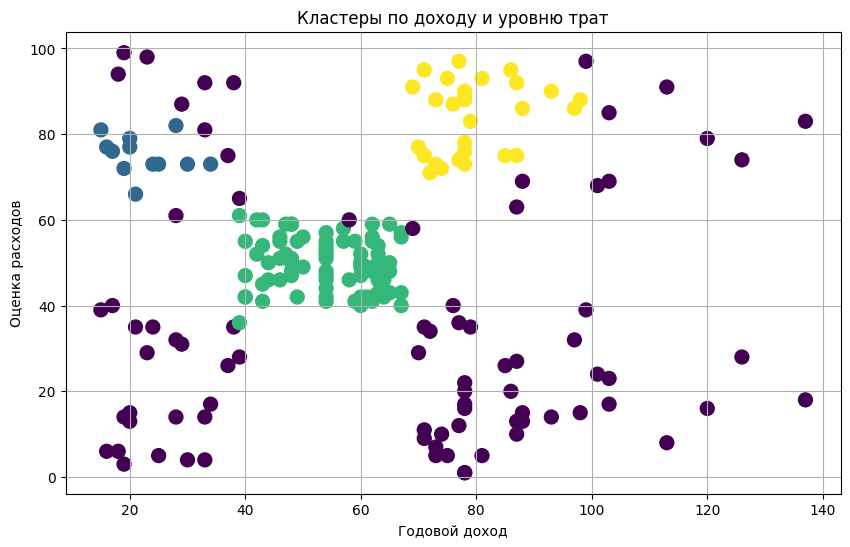

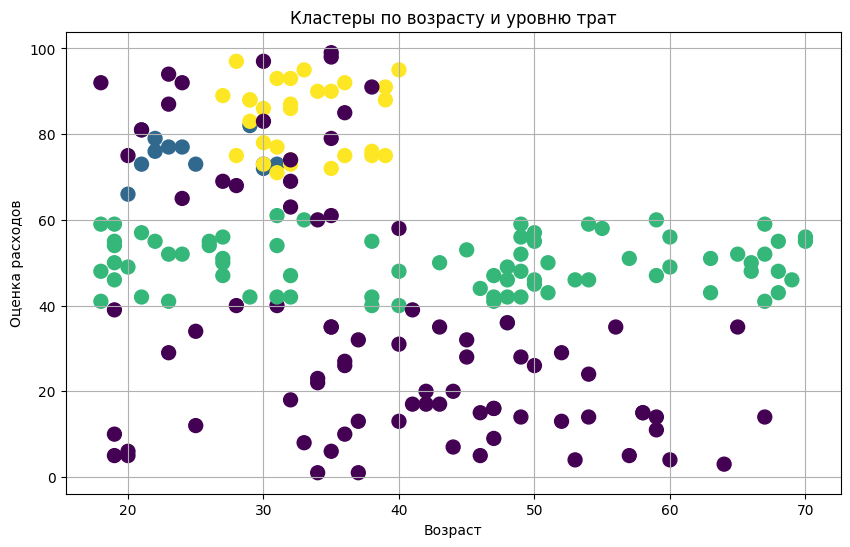

In [188]:
viz_cluster_2d(df['cluster'])

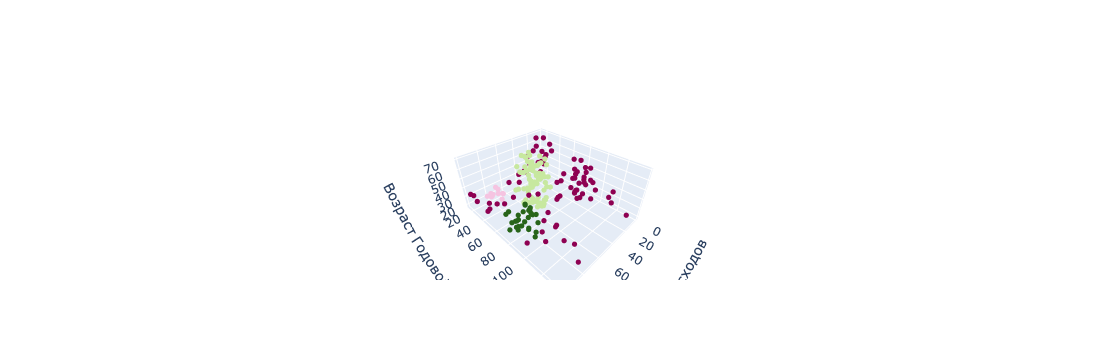

In [189]:
viz_cluster_3d()

In [178]:
# 5. Сравнить скорость работы алгоритмов. Результаты изобразить в виде таблицы.
ms_kmeans, ms_agg, ms_dbscan = [v * 1000 for v in [kmeans_delta, agglomerative_delta, dbscan_delta]]

print('Результат сравнения скорости выполнения алгоритмов')
print('--------------------------------------------------------')
print('| Название алгоритма          | Время работы алгоритма |')
print('--------------------------------------------------------')
print(f'| k-means                     | {ms_kmeans:.3f}ms                |')
print(f'| Иерархическая кластеризация | {ms_agg:.3f}ms                |')
print(f'| DBSCAN                      | {ms_dbscan:.3f}ms                |')
print('--------------------------------------------------------')

Результат сравнения скорости выполнения алгоритмов
--------------------------------------------------------
| Название алгоритма          | Время работы алгоритма |
--------------------------------------------------------
| k-means                     | 2.803ms                |
| Иерархическая кластеризация | 4.662ms                |
| DBSCAN                      | 5.799ms                |
--------------------------------------------------------


In [ ]:
# 6. Визуализировать кластеризованные данные с помощью t-SNE или UMAP если данные
# многомерные. Если данные трехмерные, то можно использовать трехмерный точечный график.